# RDKit Visualization
Visualizing some ligands using RDKit.

In [17]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/"

## Setup

In [18]:
import numpy as np
import os
import polars as pl
import pickle
import math
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import io
from PIL import Image

In [19]:
np.random.seed(44)

In [20]:
def load_from_pkl(save_path: str) -> object:
    with open(save_path, "rb") as f:
        obj = pickle.load(f)
    return obj

In [21]:
def get_triangle_number(n: int):
    return (n * (n - 1)) // 2

def get_triangle_root(tn: int):
    # solved for using quadratic formula
    # +1 here account for 0-indexing
    return int(0.5*(-1 + math.sqrt(1 + 8*tn))) + 1


def get_row(ltm_idx: int):
    return get_triangle_root(ltm_idx)


def get_ltm_idx(row: int, col: int) -> int:
    """
    In the LTM (e.g., from GetTanimotoSimMat), find the
    coefficient value between the given row/column.

    :param int row: index of molecule 1 in id_list ("row" in matrix)
    :param int col: index of molecule 2 in id_list ("column" in matrix)
    :return int: index in the LTM with coeff value
    """
    assert col < row
    offset = get_triangle_number(row)
    return offset + col


def get_row_col_from_ltm_idx(ltm_idx: int)-> tuple[int, int]:
    row = get_row(ltm_idx)
    offset = get_triangle_number(row)
    col = ltm_idx - offset
    assert get_ltm_idx(row, col) == ltm_idx
    return row, col


def get_id2idx_map(id_list: list[int]) -> dict:
    return {cpd_id: i for i, cpd_id in enumerate(id_list)}

def get_idx2id_map(id_list: list[int]) -> dict:
    return {i: cpd_id for i, cpd_id in enumerate(id_list)}

In [22]:
def find_idx_of_nearest_val(array: np.ndarray, value: float, n_idx: int = 1, k = 100):
    A = (np.abs(array - value)) 
    idx = np.argpartition(A, k)
    idx = idx[:k]
    # shuffling here to avoid indices which may be close together (giving same ligand)
    np.random.shuffle(idx) # done in-place
    return idx[:n_idx]

## Load/Process data

In [23]:
STRUCT_DIR = os.path.join(DATA_DIR, "compound_structures")

In [24]:
id_list = load_from_pkl(os.path.join(STRUCT_DIR, "similarity_id_list.pkl"))
N = len(id_list)
idx2id_map = get_idx2id_map(id_list)
sim_matrix = np.load(os.path.join(STRUCT_DIR, "similarity_lower_triangular_matrix.npy"))
ligand_smiles_df = pl.read_csv(os.path.join(STRUCT_DIR, "structure_info.tsv"), separator="\t")

In [25]:
similarity_values = np.linspace(0.0, 1.0, 3)
print(similarity_values)
n_ligandpair_per_value = 3

[0.  0.5 1. ]


In [26]:
simval2idx_map = {}
for sim_val in similarity_values:
    relevant_idx = find_idx_of_nearest_val(sim_matrix, sim_val, n_idx=n_ligandpair_per_value)
    print("%.2f" % sim_val, relevant_idx, sim_matrix[relevant_idx])
    simval2idx_map[sim_val] = relevant_idx

0.00 [24110069 14496387 14316927] [0. 0. 0.]
0.50 [ 5063803 16973492 20404479] [0.5 0.5 0.5]
1.00 [16649326 44826022 30721009] [1. 1. 1.]


In [27]:
simval2smilespair_map = {}
for sim_val in similarity_values:
    simval2smilespair_map[sim_val] = []
    for i in range(n_ligandpair_per_value):
        ltm_idx = simval2idx_map[sim_val][i]
        l1_idx, l2_idx = get_row_col_from_ltm_idx(ltm_idx)
        l1_id = idx2id_map[l1_idx]
        l2_id = idx2id_map[l2_idx]
        l1_smiles = ligand_smiles_df.filter(ligand_smiles_df["molregno"] == l1_id)["canonical_smiles"].item()
        l2_smiles = ligand_smiles_df.filter(ligand_smiles_df["molregno"] == l2_id)["canonical_smiles"].item()
        simval2smilespair_map[sim_val].append((l1_smiles, l2_smiles))

## Create visualization

In [30]:
# credit to Claude for putting this code together
def draw_molecule_pair(smiles1, smiles2, title="", mol_size=(300, 300)):
    """Draw a pair of molecules side by side"""
    # Create molecule objects
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    if mol1 is None or mol2 is None:
        print(f"Error: Could not parse SMILES strings")
        return None
    
    # Create a drawer for the pair
    drawer = rdMolDraw2D.MolDraw2DCairo(mol_size[0] * 2, mol_size[1])
    drawer.DrawMolecule(mol1)
    drawer.FinishDrawing()
    
    # Get the first molecule image
    img1_data = drawer.GetDrawingText()
    img1 = Image.open(io.BytesIO(img1_data))
    
    # Create drawer for second molecule
    drawer2 = rdMolDraw2D.MolDraw2DCairo(mol_size[0], mol_size[1])
    drawer2.DrawMolecule(mol2)
    drawer2.FinishDrawing()
    
    # Get the second molecule image
    img2_data = drawer2.GetDrawingText()
    img2 = Image.open(io.BytesIO(img2_data))
    
    # Create combined image
    combined_img = Image.new('RGB', (mol_size[0] * 2, mol_size[1]), 'white')
    combined_img.paste(img1.crop((0, 0, mol_size[0], mol_size[1])), (0, 0))
    combined_img.paste(img2, (mol_size[0], 0))
    
    return combined_img

def visualize_smiles_pairs(simval2smilespair_map: dict, include_grid: bool = False):
    """Visualize all SMILES pairs for each sim val"""
    
    # Method 1: Individual plots for each sim val
    for similarity_value, pairs in simval2smilespair_map.items():
        print(f"Similarity Value: {similarity_value}")
        
        for i, (smiles1, smiles2) in enumerate(pairs):
            # Create molecules
            mol1 = Chem.MolFromSmiles(smiles1)
            mol2 = Chem.MolFromSmiles(smiles2)
            
            if mol1 is None or mol2 is None:
                print(f"  Pair {i+1}: Error parsing SMILES")
                continue
            
            # Create figure
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle(f'Similarity Value {similarity_value:.1f}', fontsize=14, fontweight='bold')
            
            # Draw molecules
            img1 = Draw.MolToImage(mol1, size=(400, 400))
            img2 = Draw.MolToImage(mol2, size=(400, 400))
            
            ax1.imshow(img1)
            ax1.set_title('Molecule 1', fontsize=12)
            ax1.axis('off')
            
            ax2.imshow(img2)
            ax2.set_title('Molecule 2', fontsize=12)
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    # Method 2: Grid view showing all pairs
    if not(include_grid):
        return
    print("\n" + "="*50)
    print("GRID VIEW - All pairs together")
    print("="*50)
    
    n_sim_vals = len(simval2smilespair_map)
    fig, axes = plt.subplots(n_sim_vals, 2, figsize=(10, 4*n_sim_vals))
    
    if n_sim_vals == 1:
        axes = [axes]
    
    for i, (similarity_value, pairs) in enumerate(simval2smilespair_map.items()):
        # For this example, we'll take the first pair from each sim val
        if pairs:
            smiles1, smiles2 = pairs[0]
            mol1 = Chem.MolFromSmiles(smiles1)
            mol2 = Chem.MolFromSmiles(smiles2)
            
            if mol1 is not None and mol2 is not None:
                img1 = Draw.MolToImage(mol1, size=(800, 800))
                img2 = Draw.MolToImage(mol2, size=(800, 800))
                
                axes[i][0].imshow(img1)
                axes[i][0].set_title(f'Similarity Value {similarity_value:.1f} - Mol 1', fontsize=10)
                axes[i][0].axis('off')
                
                axes[i][1].imshow(img2)
                axes[i][1].set_title(f'Similarity Value {similarity_value:.1f} - Mol 2', fontsize=10)
                axes[i][1].axis('off')
            else:
                axes[i][0].text(0.5, 0.5, 'Error parsing\nSMILES', 
                               ha='center', va='center', transform=axes[i][0].transAxes)
                axes[i][1].text(0.5, 0.5, 'Error parsing\nSMILES', 
                               ha='center', va='center', transform=axes[i][1].transAxes)
                axes[i][0].axis('off')
                axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.show()

def save_molecules_as_images(simval2smilespair_map, output_dir="molecule_images"):
    """Save molecule images to files"""
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    for sim_val, pairs in simval2smilespair_map.items():
        sim_val_str = f"{sim_val:.1f}".replace('.', '_')
        
        for i, (smiles1, smiles2) in enumerate(pairs):
            mol1 = Chem.MolFromSmiles(smiles1)
            mol2 = Chem.MolFromSmiles(smiles2)
            
            if mol1 is not None:
                img1 = Draw.MolToImage(mol1, size=(800, 800))
                img1.save(f"{output_dir}/sim_val_{sim_val_str}_pair_{i+1}_mol1.png")
            
            if mol2 is not None:
                img2 = Draw.MolToImage(mol2, size=(800, 800))
                img2.save(f"{output_dir}/sim_val_{sim_val_str}_pair_{i+1}_mol2.png")
    
    print(f"Images saved to {output_dir}/ directory")

Similarity Value: 0.0


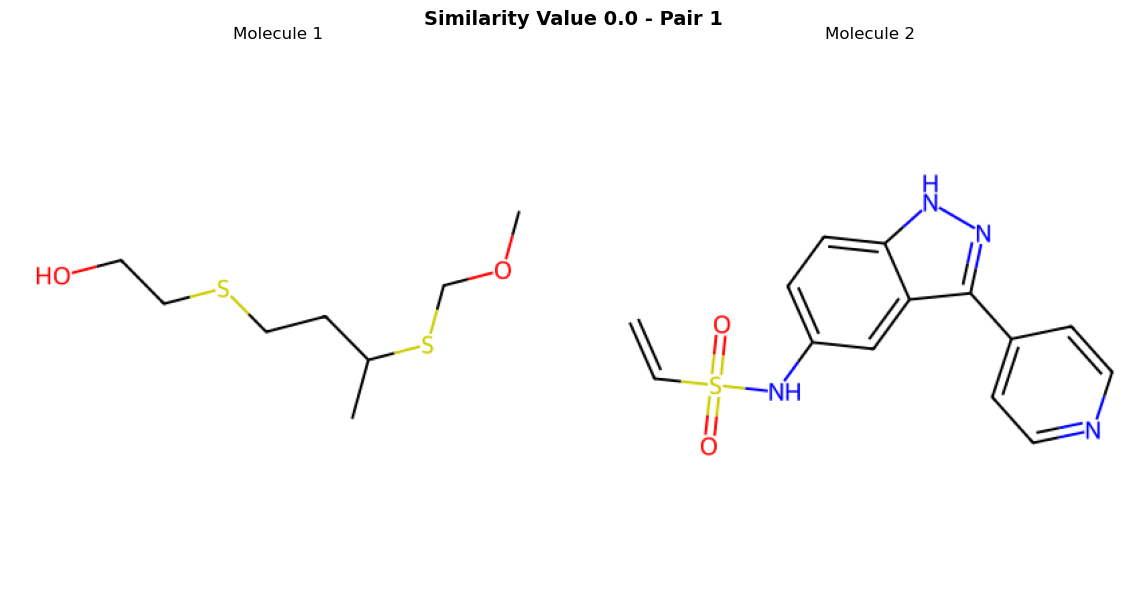

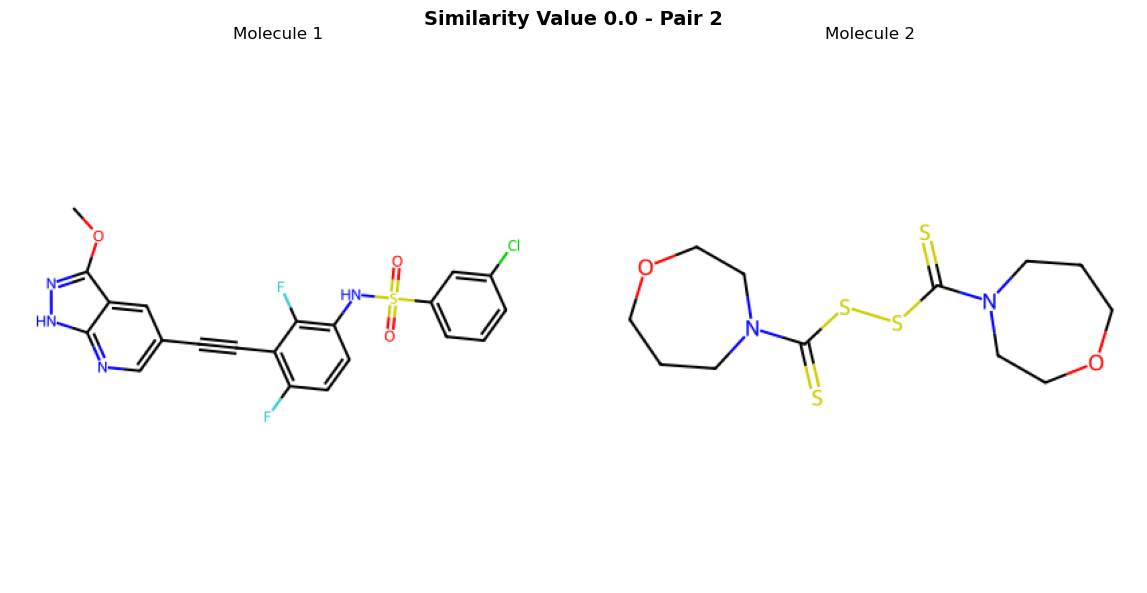

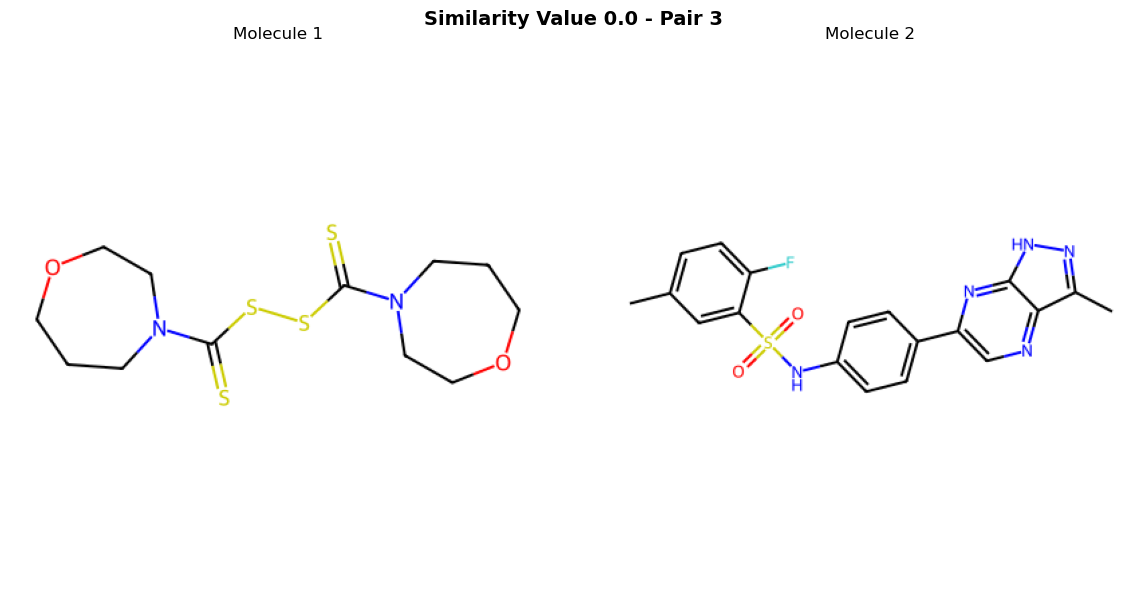

Similarity Value: 0.5


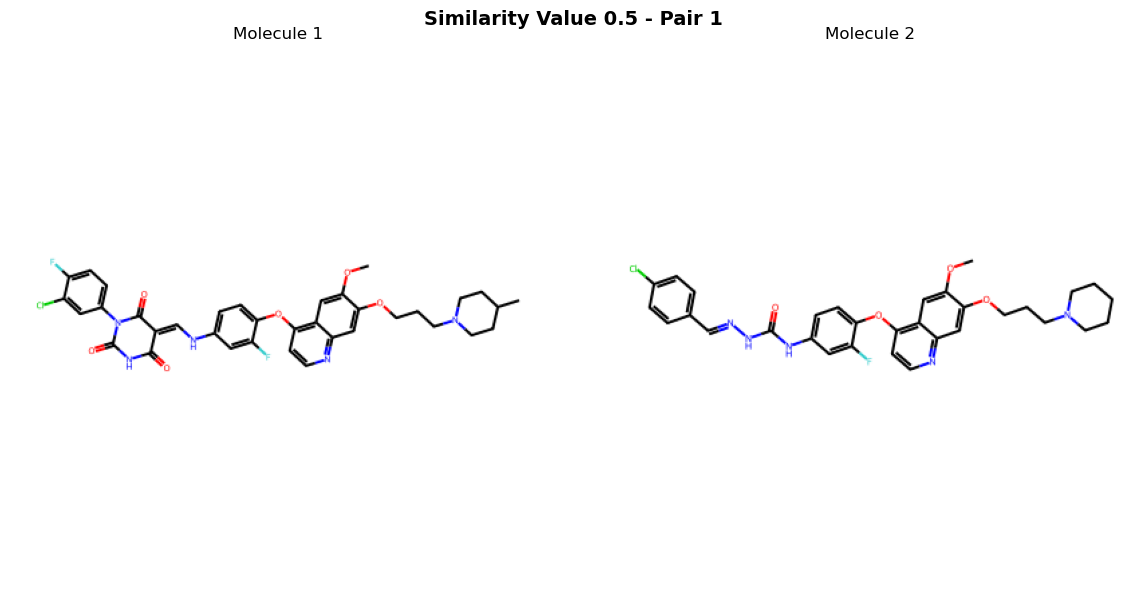

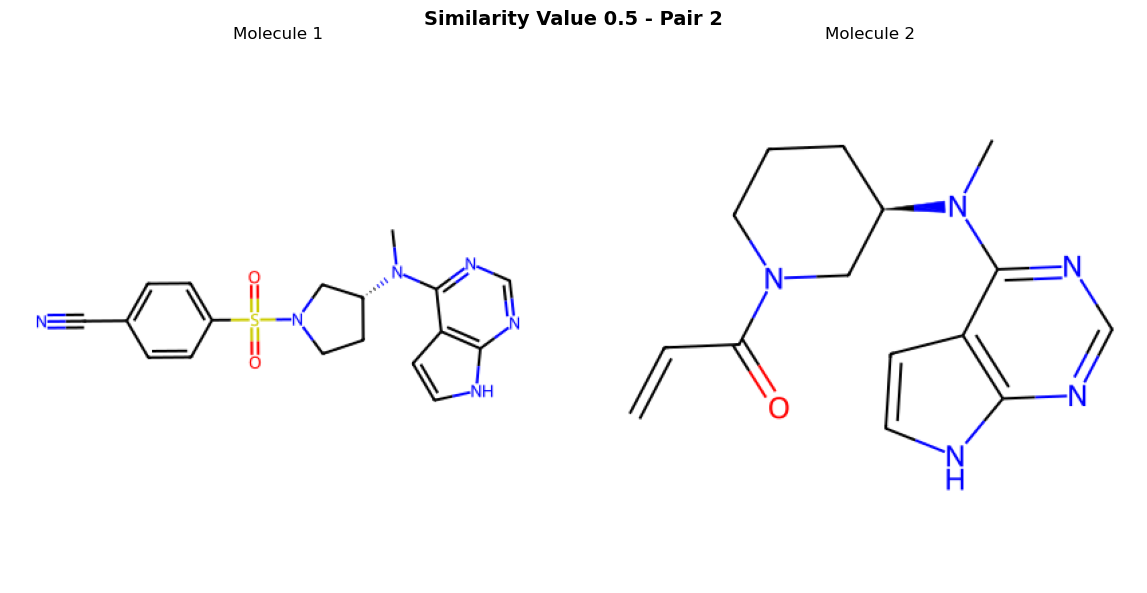

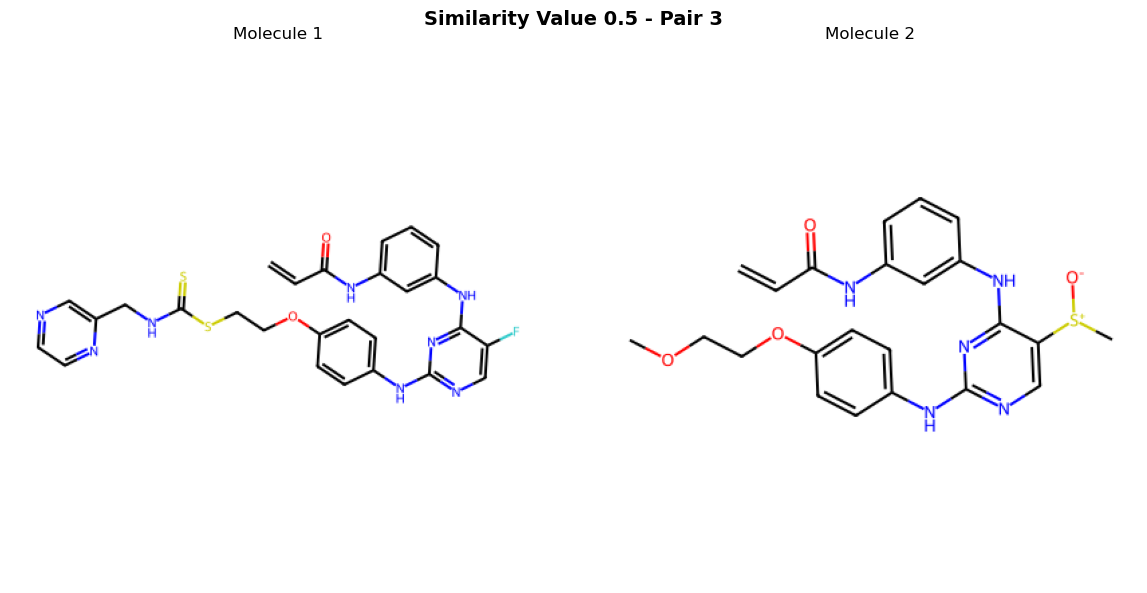

Similarity Value: 1.0


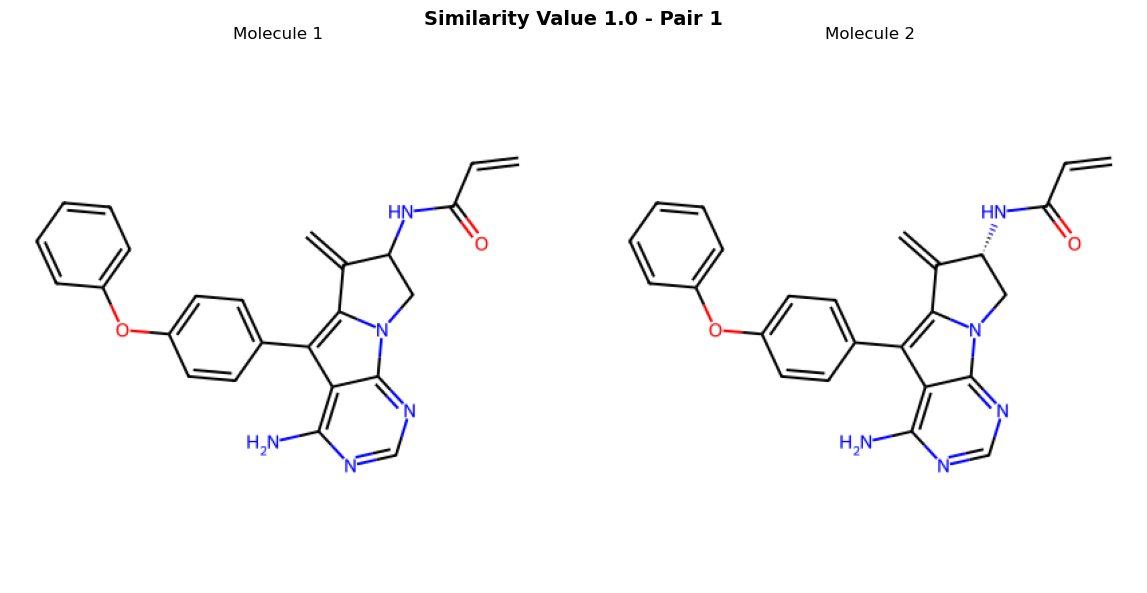

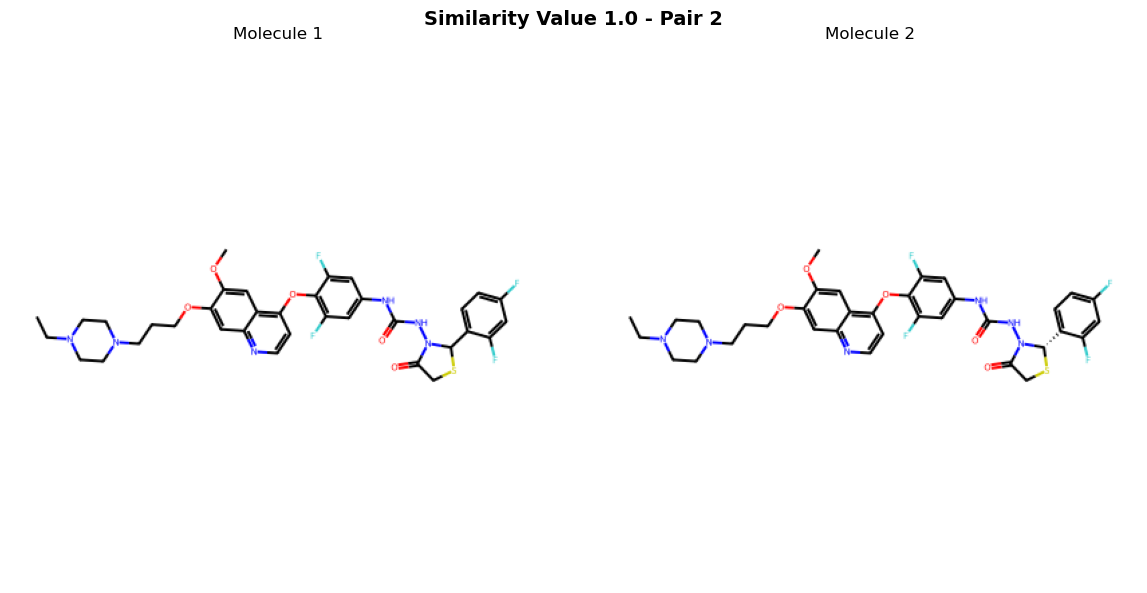

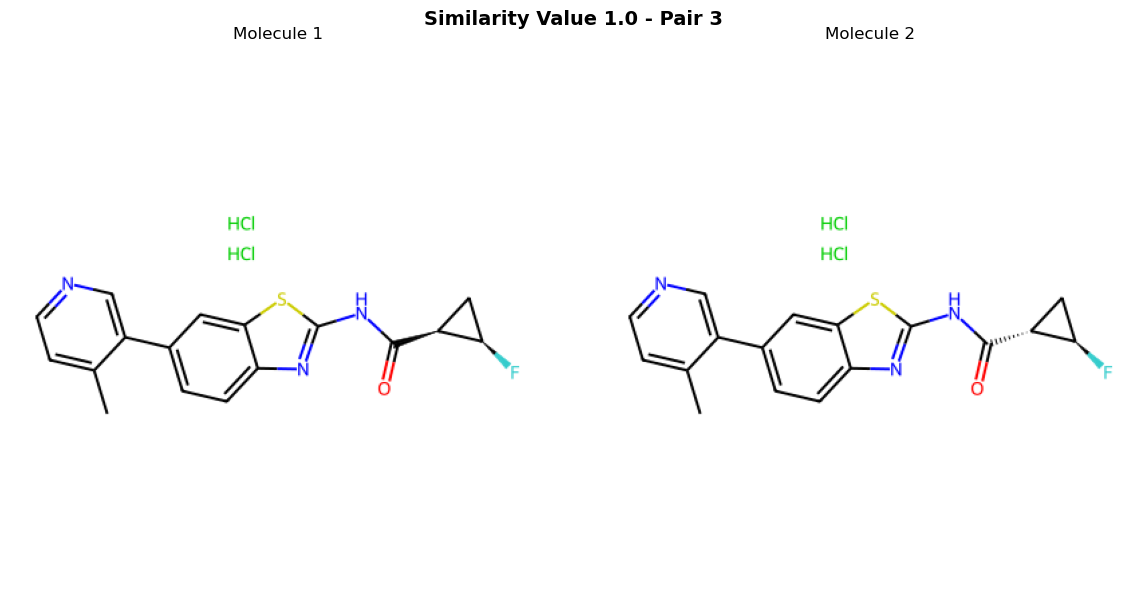

In [29]:
# TODO: label this with chembl ids instead of "Molecule 1" and "Molecule 2"
visualize_smiles_pairs(simval2smilespair_map)